# Fama French Three Factor Model Analysis

Fama French Factors were devloped by Eugene Fama and Kenneth French. Both professors of finance focusing on the deomposition of equity portfolio retuns. I am attempting to use the Fama French Three Factor model to explain the performance of a group of Large Cap Value US Equity Mutual Funds. My end goal is to determine if any of the managers are generating true "Alpha". Alpha is the portion of the performance that is not explained by the model.  

Source of Data:

Fama French 3 Factor Model: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html<br> 
Mutual fund Returns & Static data: Morningstar Direct

Fama French Three Factor definitions: <br>
> -  Small minus Big (SMB)  This factor attempts to capture the effect of investing in small cap stocks vs. large cap stocks. Small cap stocks tend to outperform large cap stocks over the long run.<br>
> -  High minus Low (HML)  This factor attempts to capture the effect of investing in value stocks vs. growth stocks. Value stocks tend to outperform over the long run.<br>
> -  Return of Market - Risk Free Rate (Mkt-RF) This factor attempts to capture the effect of the excess return market weighted portfolio. In other words, the market portfolio minus the risk free rate.

    
    

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
%matplotlib inline

Load descriptive mutual fund data. (Firm Name, Manager Tenure, AUM, Expense Ratio, etc.)

In [2]:
fund_data_temp = pd.read_csv("C:/users/edzio/desktop/Data Science Bootcamp/Python_Project/Large_Value_data2_new.csv",skipfooter = 13, engine='python')
fund_data_temp.columns = fund_data_temp.columns.str.replace('\n','')
fund_data_temp['Fund Size USD'] = fund_data_temp['Fund Size USD'].replace(",","", regex=True) 

In [3]:
keep_cols = ['Ticker','Morningstar Rating Overall','Firm Name','Manager Tenure (Average)','Fund Size USD',
             'Prospectus Adjusted Expense Ratio','StrategyId']
fund_data = fund_data_temp[keep_cols].copy()

In [4]:
fund_data.head()

,Ticker,Morningstar Rating Overall,Firm Name,Manager Tenure (Average),Fund Size USD,Prospectus Adjusted Expense Ratio,StrategyId
0,CBBZX,4,AllianceBernstein,8.03,2066229619.00,0.62,STUSA04D3X
1,AALRX,3,American Beacon,13.28,4152497953.00,0.60,STUSA0579H
2,ABCAX,4,American Beacon,7.78,1793791303.00,1.05,STUSA04E8K
3,ABECX,4,American Beacon,7.78,1793791303.00,1.82,STUSA04E8K
4,ABCVX,4,American Beacon,7.78,1793791303.00,1.08,STUSA04E8K


Load monthly Fama French returns. This file included the SMB, HML, Mkt-RF, and RF for each month.

In [5]:
fama = pd.read_csv("C:/users/edzio/desktop/Data Science Bootcamp/Python_Project/F-F_Research_Data_Factors.csv",
                   index_col = 0,skiprows =3,nrows = 1144, engine='python')

In [6]:
# adjust format of dates in Fama file to match mutual fund return file format
fama.index = pd.to_datetime(fama.index, format="%Y%M").strftime("%Y-%M")

Load monthly mutual fund returns

In [7]:
raw_mf_returns = pd.read_csv("C:/users/edzio/desktop/Data Science Bootcamp/Python_Project/Large_Value_Returns.csv",nrows = 171)

In [8]:
raw_mf_returns.drop(['Name','Base \nCurrency'], axis=1, inplace=True)

chars = [("Monthly Return",""),("USD",""),("\n","")]

for c, d in chars:
    raw_mf_returns.columns = raw_mf_returns.columns.str.replace(c,d)

raw_mf_returns = raw_mf_returns.set_index('Ticker')

In [9]:
# transpose return df to include dates down first column
mf_returns = raw_mf_returns.T

In [10]:
# set dates column  as df index
mf_returns.index = pd.to_datetime(mf_returns.index, format=" %Y-%M ").strftime("%Y-%M")

In [11]:
mf_returns = mf_returns.dropna(axis=1)

Combine mutual fund returns with the Fama French returns

In [12]:
return_data = pd.merge(mf_returns, fama, left_index=True, right_index=True)

Import statsmodels in order to do a multiple linear regression to find each funds betas for each factor

In [13]:
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

Regress the HML, SMB, Mkt-RF against each funds stream of returns. This is only done for funds that have complete returns going back to January 2011.

In [14]:
cols = ['Mkt-RF','SMB','HML']
regression_results = pd.DataFrame()

X = sm.add_constant(return_data[cols])


for column in return_data.columns[:-7]:

    data_ls = []
    y = return_data[column] - return_data['RF']
    regress = sm.OLS(y,X)
    regress_results = regress.fit()
    params = regress_results.params.copy()
    params['R2'] = regress_results.rsquared
    params['Ticker'] = column
    params['Cumulative_Return'] = ((1+ (return_data[column]/100)).cumprod()-1).iloc[-1]*100
    param = params.to_frame().T
    regression_results = pd.concat([regression_results, param], ignore_index=True, axis=0)
    
    

regression_results = regression_results.dropna(axis=1)
regression_results.rename(columns={'const':'Alpha'}, inplace=True)

In [15]:
regression_results.head()

,Alpha,Mkt-RF,SMB,HML,R2,Ticker,Cumulative_Return
0,-0.005376,0.930988,-0.035268,0.266517,0.943926,CBBZX,194.776141
1,-0.153679,1.032511,0.015456,0.366362,0.969874,AALRX,161.191973
2,-0.095936,0.943334,-0.080997,0.068001,0.974145,AICGX,203.096344
3,0.089208,0.691189,-0.107959,0.20845,0.909662,AEIMX,156.797079
4,0.086498,0.691024,-0.110701,0.211309,0.908361,AEIUX,155.495475


Merge regression results with mutual fund descriptive data

In [16]:
final_regression_results = regression_results.merge(fund_data, on='Ticker', how='left')
final_regression_results.head()

,Alpha,Mkt-RF,SMB,HML,R2,Ticker,Cumulative_Return,Morningstar Rating Overall,Firm Name,Manager Tenure (Average),Fund Size USD,Prospectus Adjusted Expense Ratio,StrategyId
0,-0.005376,0.930988,-0.035268,0.266517,0.943926,CBBZX,194.776141,4,AllianceBernstein,8.03,2066229619.00,0.62,STUSA04D3X
1,-0.153679,1.032511,0.015456,0.366362,0.969874,AALRX,161.191973,3,American Beacon,13.28,4152497953.00,0.60,STUSA0579H
2,-0.095936,0.943334,-0.080997,0.068001,0.974145,AICGX,203.096344,4,American Century Investments,1.42,3070714682.00,0.46,STUSA04D52
3,0.089208,0.691189,-0.107959,0.20845,0.909662,AEIMX,156.797079,3,American Century Investments,17.67,12172423114.00,0.01,STUSA04ADR
4,0.086498,0.691024,-0.110701,0.211309,0.908361,AEIUX,155.495475,3,American Century Investments,17.67,12172423114.00,0.72,STUSA04ADR


In [17]:
# convert data types from object to float
final_regression_results[['Alpha','Mkt-RF','SMB','HML','Cumulative_Return','R2','Fund Size USD']] = final_regression_results[['Alpha','Mkt-RF','SMB','HML','Cumulative_Return','R2','Fund Size USD']].apply(pd.to_numeric)

In [18]:
final_regression_results['Alpha_cat'] = np.where(final_regression_results['Alpha']>0, 'positive','negative')

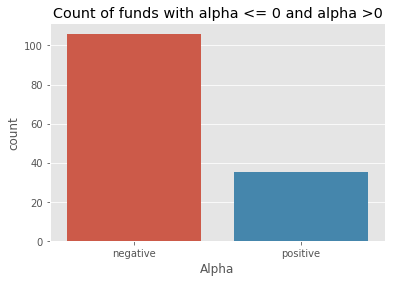

In [19]:
ax = sns.countplot(x="Alpha_cat", data=final_regression_results);
ax.set(xlabel='Alpha');
ax.set(title = 'Count of funds with alpha <= 0 and alpha >0' );

Create boxplot to see the distribution of the Factors

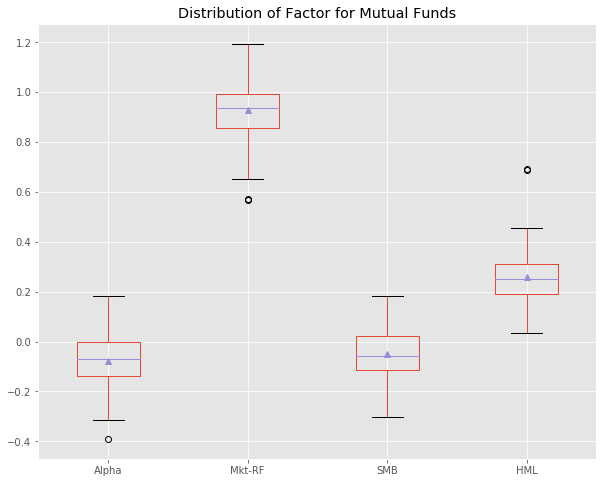

In [20]:
boxplot = final_regression_results.boxplot(column=['Alpha', 'Mkt-RF','SMB','HML'], figsize=(10,8), showmeans=True);
boxplot.set_title('Distribution of Factor for Mutual Funds');

Create boxplot for all funds that have postive alpha

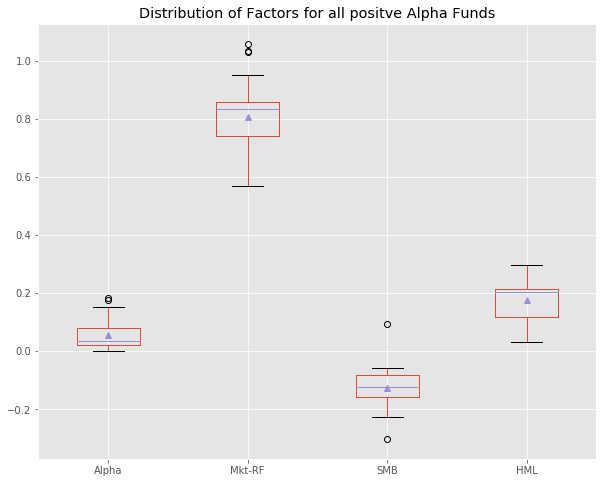

In [21]:
positive_alpha = final_regression_results[final_regression_results['Alpha'] >0]
negative_alpha = final_regression_results[final_regression_results['Alpha'] <=0]

positive_alpha_box = positive_alpha.boxplot(column=['Alpha', 'Mkt-RF','SMB','HML'], figsize=(10,8), showmeans=True);
positive_alpha_box.set_title('Distribution of Factors for all positve Alpha Funds');


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


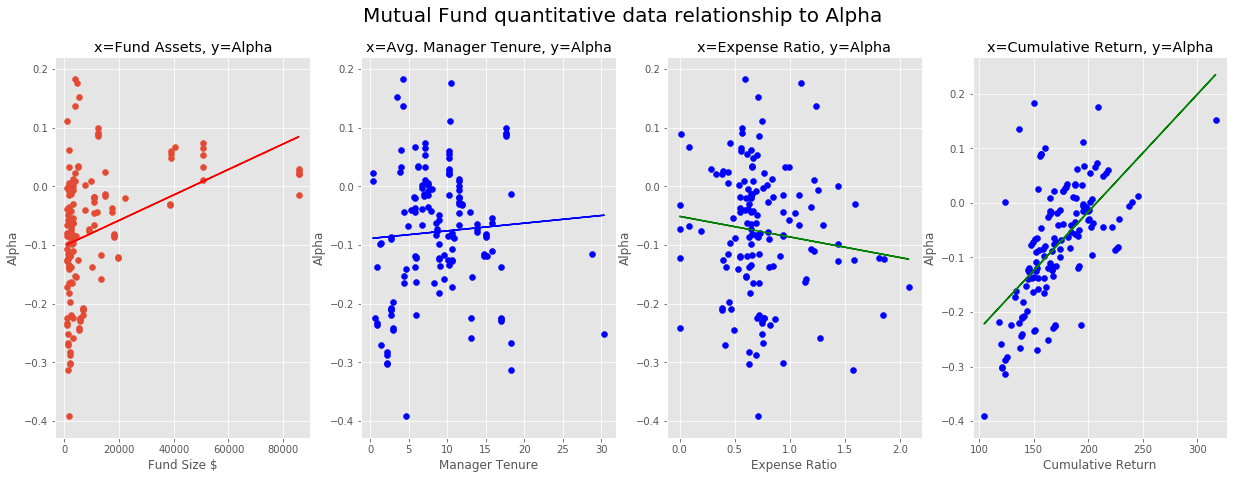

In [22]:
fig, axes = plt.subplots(1,4, figsize=(21,7))
fig.suptitle('Mutual Fund quantitative data relationship to Alpha', fontsize=20)

x = final_regression_results['Fund Size USD']/1000000
y = final_regression_results['Alpha']
axes[0].scatter(x, y);
z0 = np.polyfit(x, y,1)
p = np.poly1d(z0)
axes[0].plot(x,p(x),"r-")
axes[0].set_xlabel('Fund Size $')
axes[0].set_ylabel('Alpha')
axes[0].title.set_text('x=Fund Assets, y=Alpha')

x = final_regression_results['Manager Tenure (Average)']
axes[1].scatter(x, y, color='b');
z0 = np.polyfit(x, y,1)
p = np.poly1d(z0)
axes[1].plot(x,p(x),"b-")
axes[1].set_xlabel('Manager Tenure')
axes[1].set_ylabel('Alpha')
axes[1].title.set_text('x=Avg. Manager Tenure, y=Alpha')

x = final_regression_results['Prospectus Adjusted Expense Ratio']
axes[2].scatter(x, y, color='b');
z0 = np.polyfit(x, y,1)
p = np.poly1d(z0)
axes[2].plot(x,p(x),"g-")
axes[2].set_xlabel('Expense Ratio')
axes[2].set_ylabel('Alpha')
axes[2].title.set_text('x=Expense Ratio, y=Alpha')

x = final_regression_results['Cumulative_Return']
axes[3].scatter(x, y, color='b');
z0 = np.polyfit(x, y,1)
p = np.poly1d(z0)
axes[3].plot(x,p(x),"g-")
axes[3].set_xlabel('Cumulative Return')
axes[3].set_ylabel('Alpha')
axes[3].title.set_text('x=Cumulative Return, y=Alpha')


Rolling 60 months regression. I wanted to take a look at the rolling 60 month regression to see if there were any trends there to help explain alpha generation, or lack thereof.

In [23]:
cols = ['Mkt-RF','SMB','HML']
df_temp = return_data.index.copy()
rolling_results = pd.DataFrame()

X_roll = sm.add_constant(return_data[cols])

for column in return_data.columns[:-7]:

    data_ls = []
    y_roll = return_data[column] - return_data['RF']
    rols = RollingOLS(y_roll,X_roll, window=60)
    results = rols.fit()
    params = results.params.copy()
    params['Ticker'] = column
    params['Date'] = df_temp
    params['R2'] = results.rsquared
    params.set_index('Date')
    params = params.dropna(axis=0)
    params['Rolling_Return'] = ((return_data[column]/100)+1).rolling(60).apply(np.prod)-1
    rolling_results = pd.concat([rolling_results, params], ignore_index=True, axis=0)
    
    
rolling_results.rename({'const':'Alpha'},axis=1, inplace=True)
rolling_results = rolling_results.dropna(axis=0)

In [24]:
avg_rolling_data = rolling_results.groupby('Date').mean()

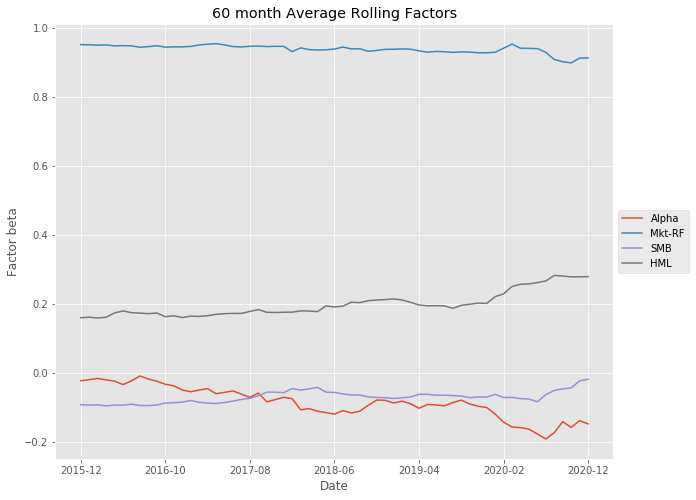

In [25]:
avg_rolling_data[['Alpha','Mkt-RF','SMB','HML']].plot(legend=True, figsize=(10,8),title = '60 month Average Rolling Factors', ylabel='Factor beta').legend(loc='center left', bbox_to_anchor=(1.0,0.5));

In [26]:
ed = rolling_results.groupby('Ticker').filter(lambda x: x['Alpha'].mean() > 0).groupby('Date').mean()

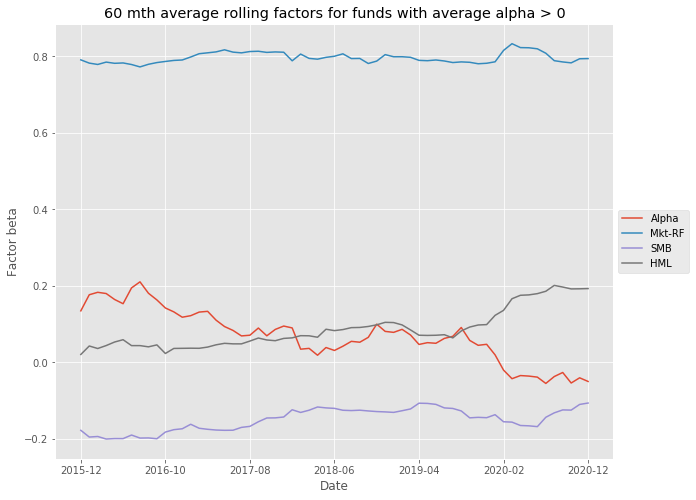

In [27]:
ed[['Alpha','Mkt-RF','SMB','HML']].plot(legend=True, figsize=(10,8), title = '60 mth average rolling factors for funds with average alpha > 0', ylabel='Factor beta').legend(loc='center left', bbox_to_anchor=(1.0,0.5));

# Final Analysis

1. Most fund do not produce any alpha. this is demonstarted by the count of funds with positive alpha vs the funds with negative alpha. This can also be seen by looking at the distribution of factors for the funds. The alpha distribution's 75th percentile is just at 0.


2. For the funds that produce positive alpha, the distribution of factors do show some outliers. The presence of these outliers lead me to think that these funds may differentiating themselves and holding stocks and/or differing weighting that most of their peers in the category.


3. As expected, there was a postive correlation of alpha to fund assets, and cumulative return as well as a negative correlation of alpha to the amount of expenses charged to the fund for management. Alpha showed a slight positve correlation to the lenght of manager tenure.


4. The 60 month rolling regression shows that alpha generation has been on a declining trend towards the later years in the 10 year window. This trend is also present in the group of funds that have an average positve alpha for the entire period. this may be the result of a growth/momentum market while value is currently out of favor.